In [1]:
# Required imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as ms


import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package wordnet to /home/bibek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bibek/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Utility functions
# PRE PROCESSING FUNCTIONS
nltk_wordnet_tag_map = {
    'NN': wn.NOUN,
    'NNS': wn.NOUN,
    'VBP': wn.VERB,
    'VBG': wn.VERB,
    'JJ': wn.ADJ,
}

from functools import reduce
import string
import re

def compose(*functions):
    def compose2(f1, f2):
        """Compose two functions"""
        return lambda *args: f1(f2(*args))
    return reduce(compose2, functions)

def translate_to_english_txt(row):
    text = row["excerpt"]
    try:
        if langid.classify(text)[0] != 'en':
            trans = googletrans.client.Translator()
            return trans.translate(text, 'en').text
        return text
    except Exception as e:
        return ''
    
def lemmatize(row, lemmatizer=WordNetLemmatizer()):
    text = row
    splitted = text if type(text) == list else str(text).split()
    splitted = list(map(lambda x: str(x).lower(), splitted))
    tagged = nltk.pos_tag(splitted)
    lemmatized = []
    for word, tag in tagged:
        wnet_tag = nltk_wordnet_tag_map.get(tag)
        if wnet_tag:
            lemmatized.append(lemmatizer.lemmatize(word, wnet_tag))
        else:
            lemmatized.append(word)
    return ' '.join(lemmatized)

def rm_punc_not_nums(inp, col=None):
    """Remove punctuation unless it's a number for either a df (and col)
    or single entry
    """
    punc = string.punctuation
    transtable = str.maketrans("", "", punc)

    def sing_rm(phr):
        """Remove for a single entity"""
        return ' '.join([re.sub('\W+', '', i).translate(transtable) if not (
                    all(j.isdigit() or j in punc for j in i)
                    and
                    any(j.isdigit() for j in i)
                ) else re.sub('\W+', '', i)
                for i in str(phr).split(' ')]
        )
    if col and isinstance(inp, pd.core.frame.DataFrame):
        return inp.filter(like=col).applymap(lambda phr: sing_rm(phr))
    elif isinstance(inp, str):
        return sing_rm(inp)
    else:
        raise Exception('Not a vaild type')


def rm_stop_words_txt(txt, swords=nltk.corpus.stopwords.words('english')):
    """ Remove stop words from given text """
    return ' '.join(
        [token for token in str(txt).split(' ')
            if token.lower() not in swords]
    )

def preprocess(row):
    inp = row["excerpt"]
    inp = lemmatize(inp)
    func = compose(
        rm_punc_not_nums,
        rm_stop_words_txt,
        ' '.join,
        str.split,
        str.lower,
        str
    )

    return func(inp)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def model_cross_validate(features, labels, model):
    print ("Cross Validating: {0}".format(model["name"]))
    print ("features shape", features.shape)
    print ("Labels shape", labels.shape)
    scoring = ['accuracy', 'precision_macro', 'recall_macro']
    scores = cross_validate(model["model"], features, labels, scoring=scoring, cv=ms.KFold(n_splits=10, shuffle = True, random_state=7), return_train_score=False)
    k = list(range(10))
    plt.scatter(k, scores['test_accuracy'])
    plt.scatter(k, scores['test_precision_macro'])
    plt.scatter(k, scores['test_recall_macro'])
    plt.ylabel("Percentage")
    plt.xlabel("Iteration")
    plt.title("{0} 10 Folds Cross Validation".format(model["name"]))
    plt.legend(['Testing Accuracy', 'Testing Precision', 'Testing Recall'], loc='upper left')

In [54]:
# Create data frame

def create_data_frame():
    df = pd.read_csv("../_playground/sample_data/processed_sectors_subsectors.csv", nrows=1000)
    df.drop_duplicates(["excerpt"], inplace=True)
    #df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1, inplace=True)
    df["preprocessed_excerpt"] = df.apply(preprocess, axis=1)
    return df

#df = create_data_frame()

In [4]:
# KNearest Neighbor classifier

from sklearn.neighbors import KNeighborsClassifier
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec


def getVector(row, model):
    return model.infer_vector(row["preprocessed_excerpt"])

def create_doc2vec_model(df):
    train, test = train_test_split(df, test_size=0.1, random_state=42)
    train_tagged = train.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['preprocessed_excerpt']), tags=[r.sector]), axis=1)
    test_tagged = test.apply(
        lambda r: TaggedDocument(words=tokenize_text(r['preprocessed_excerpt']), tags=[r.sector]), axis=1)
    model_dbow = Doc2Vec(dm=0, vector_size=50, negative=5, hs=0, min_count=2, sample = 0)
    model_dbow.build_vocab([x for x in train_tagged.values])
    return model_dbow

def get_vec_features(df):
    d2v_model = create_doc2vec_model(df)
    df["feature_vector"] = df.apply(lambda x: getVector(x, d2v_model), axis=1)
    # df.drop(["subsector"], inplace=True, axis=1)
    dummies = pd.get_dummies(df["sector"])
    oh_df = pd.concat([dummies, df], axis=1)
    return oh_df

def get_features_labels_for_KNN(df, name="KNearestNeighbors", **knn_params):
    oh_df = get_vec_features(df)
    features = np.array(list(oh_df["feature_vector"]))
    oh_df["sector"] = oh_df["sector"].astype("category", copy=False)
    labels = np.array(oh_df.iloc[:,:12])
    knn = KNeighborsClassifier(n_neighbors=5, **knn_params)
    return name, knn, features, labels


In [5]:
# Logistic Regression Classifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
    

def get_features_labels_for_logistic_regression(df, name="LogisticRegression", **logistic_regression_params):
    lr = LogisticRegression(C=1, solver='lbfgs', multi_class='multinomial', **logistic_regression_params)
    oh_df = get_vec_features(df)
    features = np.array(list(oh_df["feature_vector"]))
    oh_df["sector"] = oh_df["sector"].astype("category", copy=False)
    labels = np.array(oh_df["sector"])
    return name, lr, features, labels

In [11]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

def get_features_labels_for_random_forest(df, name="RandomForest", **random_forest_params):
    rf = RandomForestClassifier(**random_forest_params)
    df["preprocessed_excerpt"] = df.apply(preprocess, axis=1)
    text_clf = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 2))),
        ('tfidf', TfidfTransformer(use_idf=False)),

    ])
    features = text_clf.fit_transform(df["preprocessed_excerpt"])
    labels = df["sector"]
    return name, rf, features, labels

def get_features_labels_for_random_forest_PCA(df, name="RandomForestPCA", n_components=100, **random_forest_params): 
    rf = RandomForestClassifier(**random_forest_params)
    df["preprocessed_excerpt"] = df.apply(preprocess, axis=1)
    text_clf = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1, 2))),
        ('tfidf', TfidfTransformer(use_idf=False)),
        ('pca', TruncatedSVD(n_components=n_components)),
    ])
    features = text_clf.fit_transform(df["preprocessed_excerpt"])
    labels = df["sector"]
    return "{}{}".format(name, n_components), rf, features, labels


In [7]:
# NAIVE BAYES
from sklearn.naive_bayes import MultinomialNB

def get_features_labels_for_naive_bayes(df, name="NaiveBayesTF", **naive_bayes_params):
    feature_extractor = Pipeline([
            ('vect', CountVectorizer(ngram_range=(1, 2))),
            ('tfidf', TfidfTransformer(use_idf=False)),
        ])
    nb = MultinomialNB(alpha=0.01, fit_prior=False)
    df["preprocesssed_excerpt"] = df.apply(preprocess, axis=1)
    features = feature_extractor.fit_transform(df["preprocessed_excerpt"])
    labels = df["sector"]
    return name, nb, features, labels

def get_features_labels_for_naive_bayes_tfidf(df, name="NaiveBayesTFIDF", **naive_bayes_params):
    feature_extractor = Pipeline([
            ('vect', CountVectorizer(ngram_range=(1, 2))),
            ('tfidf', TfidfTransformer(use_idf=True)),
        ])
    nb = MultinomialNB(alpha=0.01, fit_prior=False)
    df["preprocesssed_excerpt"] = df.apply(preprocess, axis=1)
    features = feature_extractor.fit_transform(df["preprocessed_excerpt"])
    labels = df["sector"]
    return name, nb, features, labels

RandomForest: 0.514293 (0.089864)
LogisticRegression: 0.267384 (0.096326)
KNearestNeighbors: 0.035293 (0.018227)
NaiveBayesTF: 0.316535 (0.062492)
NaiveBayesTFIDF: 0.222838 (0.042724)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RandomForestPCA100: 0.410384 (0.067195)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RandomForestPCA50: 0.419424 (0.091534)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RandomForestPCA20: 0.433636 (0.085708)


/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/bibek/venvs/deeplenv/l

RandomForestPCA10: 0.397283 (0.073658)


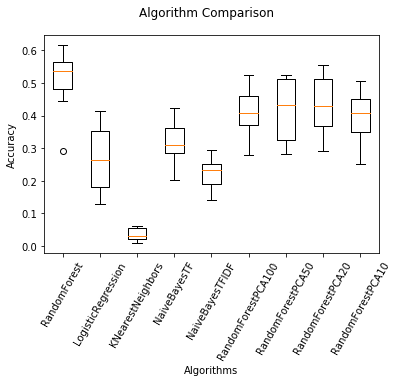

In [55]:
def compare_models(models_X_Y):
    """
    @models_X_Y: [(modelname, model, X, Y), ...]
    """
    scoring = 'accuracy'
    seed = 7
    results = []
    names = [x[0] for x in models_X_Y]
    for name, model, X, Y in models_X_Y:
        kfold = ms.KFold(n_splits=10, random_state=seed)
        cv_results = ms.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    ax.set_xlabel("Algorithms")
    ax.set_ylabel("Accuracy")
    plt.xticks(rotation=60)
    plt.show()

models_X_Y = []

df = create_data_frame()

models_X_Y.append(
    get_features_labels_for_random_forest(df.copy(), n_estimators=300)
)
models_X_Y.append(
    get_features_labels_for_logistic_regression(df.copy())
)
models_X_Y.append(
    get_features_labels_for_KNN(df.copy())
)
models_X_Y.append( ## NAIVE BAYES WITH TF only (no IDF)
    get_features_labels_for_naive_bayes(df.copy())
)

models_X_Y.append( ## NAIVE BAYES WITH TFIDF
    get_features_labels_for_naive_bayes_tfidf(df.copy())
)

models_X_Y.append( ## Random Forest WITH dimension reduced TFIDF
    get_features_labels_for_random_forest_PCA(df.copy())
)
models_X_Y.append( ## Random Forest WITH dimension reduced TFIDF
    get_features_labels_for_random_forest_PCA(df.copy(), n_components=50)
)
models_X_Y.append( ## Random Forest WITH dimension reduced TFIDF
    get_features_labels_for_random_forest_PCA(df.copy(), n_components=20)
)
models_X_Y.append( ## Random Forest WITH dimension reduced TFIDF
    get_features_labels_for_random_forest_PCA(df.copy(), n_components=10)
)
compare_models(models_X_Y)

training time RandomForest: 14.403898000717163
testing time RandomForest: 0.28387451171875
training time LogisticRegression: 0.08307886123657227
testing time LogisticRegression: 0.0014793872833251953
training time KNearestNeighbors: 0.006361722946166992
testing time KNearestNeighbors: 0.09938859939575195
training time NaiveBayesTF: 0.04214334487915039
testing time NaiveBayesTF: 0.003963470458984375
training time NaiveBayesTFIDF: 0.03929257392883301
testing time NaiveBayesTFIDF: 0.0032320022583007812
training time RandomForestPCA100: 0.1867210865020752
testing time RandomForestPCA100: 0.0063097476959228516
training time RandomForestPCA50: 0.13308358192443848
testing time RandomForestPCA50: 0.0056095123291015625
training time RandomForestPCA20: 0.0904855728149414
testing time RandomForestPCA20: 0.006192922592163086
training time RandomForestPCA10: 0.0724344253540039
testing time RandomForestPCA10: 0.0054931640625


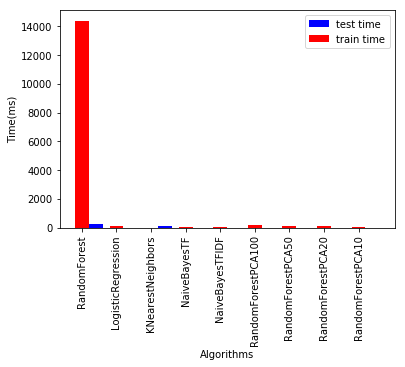

In [57]:
## Benchmark the speeds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import time

def benchmark_speed(models):
    names = []
    test_times = []
    train_times = []
    for name, model, X, Y in models:
        names.append(name)
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
        ## training_time
        t0 = time.time()
        model.fit(X_train, y_train)
        t1 = time.time()
        print("training time {}: {}".format(name, t1-t0))
        train_times.append(t1-t0)
        
        ## test time
        t0 = time.time()
        predicted = model.predict(X_test)
        t1 = time.time()
        print("testing time {}: {}".format(name, t1-t0))
        test_times.append(t1-t0)

    test_times = np.array(test_times) * 1000  # convert to ms
    train_times = np.array(train_times) * 1000 # convert to ms
    ax = plt.subplot(111)
    barwidth = 20
    xax = np.arange(len(names))*2.5*barwidth
    
    ax.bar(xax, train_times, width=barwidth, color='r', label='train time')
    ax.bar(xax+ barwidth, test_times, width=barwidth, color='b', label='test time')
    # Set ticks and labels
    ax.set_xticks(xax)
    ax.set_xticklabels(names)
    ax.set_xlabel("Algorithms")
    ax.set_ylabel("Time(ms)")
    # Set legends
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    plt.xticks(rotation=90)
    plt.show()

benchmark_speed(models_X_Y)